In [13]:
import warnings
warnings.filterwarnings('ignore')

import glob
import imageio
import json
import numpy as np
import pandas as pd
import os
import scipy
import shutil
import tensorflow as tf
import zipfile

from PIL import Image

## Read in data

In [16]:
with open("F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9\metadata.json", 'r') as f:
    colony_pic_metadata_json = f.read()
    colony_pic_metadata = json.loads(colony_pic_metadata_json)

In [3]:

def deep_find_dict(dict_: dict, key, default_val=-1) -> list:
    """
    Finds and returns the associated value of the key in a nested dictionary.
    If a key appears multiple times in a nested dictionary, it returns the first value.
    If the key does not appear in the nested dictionary, returns default_val
    Inputs:
        dict_: Target dictionary
        key: Target key name
        default_val(default = -1): value returned if key does not appear in the nested dictionary
    Returns:
        res: value of first appearance of associated key in the given dictionary
    """
    if key in dict_.keys():
        return dict_[key]
    else:
        for int_key, val in dict_.items():
            if isinstance(dict_[int_key], dict):
                res = deep_find_dict(dict_[int_key], key)
                if res is not None: return res
    return default_val

def extract_paths_with_colonies(json_: dict, min_colonies: int=1, max_colonies: int=-1, path: str='Relative Path'):
    """
    Returns relative file paths of all files with non-zero colony counts
    Inputs:
        json_: JSON file containing the metadata of the plate photographs.
        min_colonies: minimum number of colonies desired on returned images.
        max_colonies: maximum number of colonies desired on returned images.
    Returns:
        img_paths: list of tuples of the colony count and the relative file paths of images containing between 
            min_colonies and max_colonies number of colonies.
    """
    img_paths = list()
    if max_colonies == -1:
        max_colonies = np.Inf
    for key, val in json_.items():
        colony_count = deep_find_dict(val, 'Bacterial Load Estimation')
        if (colony_count >= min_colonies) and (colony_count <= max_colonies):
            img_paths.append((colony_count, val['Relative Path']))
    return img_paths

def flatten(test_list):
    """
    https://stackoverflow.com/questions/12472338/flattening-a-list-recursively
    Recursively flattens a nested listed into a list of non-list elements.
    Inputs:
        test_list: list to be flattened
    Returns:
        A flattened version of test_list, containing all the elements contained in test_list and its list elements 
        flattened.
    """
    if isinstance(test_list, list):
        if len(test_list) == 0:
            return []
        first, rest = test_list[0], test_list[1:]
        return flatten(first) + flatten(rest)
    else:
        return [test_list]

In [76]:
img_paths = extract_paths_with_colonies(colony_pic_metadata['images_list'])

In [77]:
len(img_paths)

126

## Extract zipfiles

In [25]:
zip_files = glob.glob("F:\Colonies_Data\*.zip")
zip_files

['F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part18.zip',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part17.zip',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part15.zip',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part16.zip']

In [26]:
for file_loc in zip_files:
    with zipfile.ZipFile(file_loc, 'r') as zf:
        print(f"Extracting {file_loc}.")
        zf.extractall(path="F:\Colonies_Data\\")
    os.remove(file_loc)
    print(f"Removed {file_loc}.")

Extracting F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part18.zip.
Removed F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part18.zip.
Extracting F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part17.zip.
Removed F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part17.zip.
Extracting F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part15.zip.
Removed F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part15.zip.
Extracting F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part16.zip.
Removed F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part16.zip.


## Finding usable images (Windows)

In [4]:
plate_metadata = glob.glob('F:\Colonies_Data\*\metadata.json')
plate_metadata

['F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part3\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part4\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part1\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part6\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part5\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part2\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part7\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part12\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part8\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counte

In [5]:
all_img_paths = list()
for metadata_loc in plate_metadata:
    absolute_path = metadata_loc.split("\\metadata.json")[0]
    with open(metadata_loc, 'r') as f:
        colony_pic_metadata_json = f.read()
        colony_pic_metadata = json.loads(colony_pic_metadata_json)
    img_paths = extract_paths_with_colonies(colony_pic_metadata['images_list'], max_colonies=99 )
    full_img_paths = [(path[0], absolute_path + '/' + path[1]) for path in img_paths]
    all_img_paths.append(full_img_paths)
all_img_paths = flatten(all_img_paths)

In [6]:
len(all_img_paths)

1204

In [7]:
all_img_paths[0:3]

[(1,
  'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9/F/T4h_inf/IMG_Niguarda1_127_121_F6_T543.png'),
 (2,
  'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9/S/T4h_inf/IMG_Niguarda1_1352_710_S54_T962.png'),
 (6,
  'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9/F/T4h_inf/IMG_Niguarda1_1421_610_F6_T541.png')]

## Image Processing

In [8]:
Lt100_colonies_images = [t[1] for t in all_img_paths]

In [12]:
ex_img_path = Lt100_colonies_images[0]
ex_img = imageio.imread(ex_img)

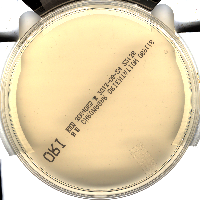

In [19]:
Image.fromarray(ex_img).resize((200, 200))

In [17]:
np.array(Image.open(ex_img_path).convert('L')).shape

(3314, 3314)